Loading dataset...
Data loading took 0.45 seconds.
Train shape: (512, 3), Test shape: (128, 3)

Generating 7-mers...
K-mer generation took 0.17 seconds.

Extracting features using TF-IDF (max_features=None)...
TF-IDF vectorization took 0.61 seconds.
Train feature matrix shape: (512, 16384)
Test feature matrix shape: (128, 16384)

Encoding labels...
Number of classes: 128

Training LinearSVC with C=130 on ORIGINAL TF-IDF data...
Model training took 89.53 seconds.

Evaluating model on the original TF-IDF test set...

--- Final F1 Scores ---
Final F1 Score on Test Set (macro): 0.0584
Final F1 Score on Test Set (weighted): 0.0584

--- Starting Boundary Visualization ---

Applying PCA to ORIGINAL TF-IDF features to 2 components...
PCA transformation took 0.27 seconds.
Explained variance ratio by 2 components: 0.0442

Creating grid and predicting for boundary visualization...
Grid creation and prediction took 1.42 seconds.


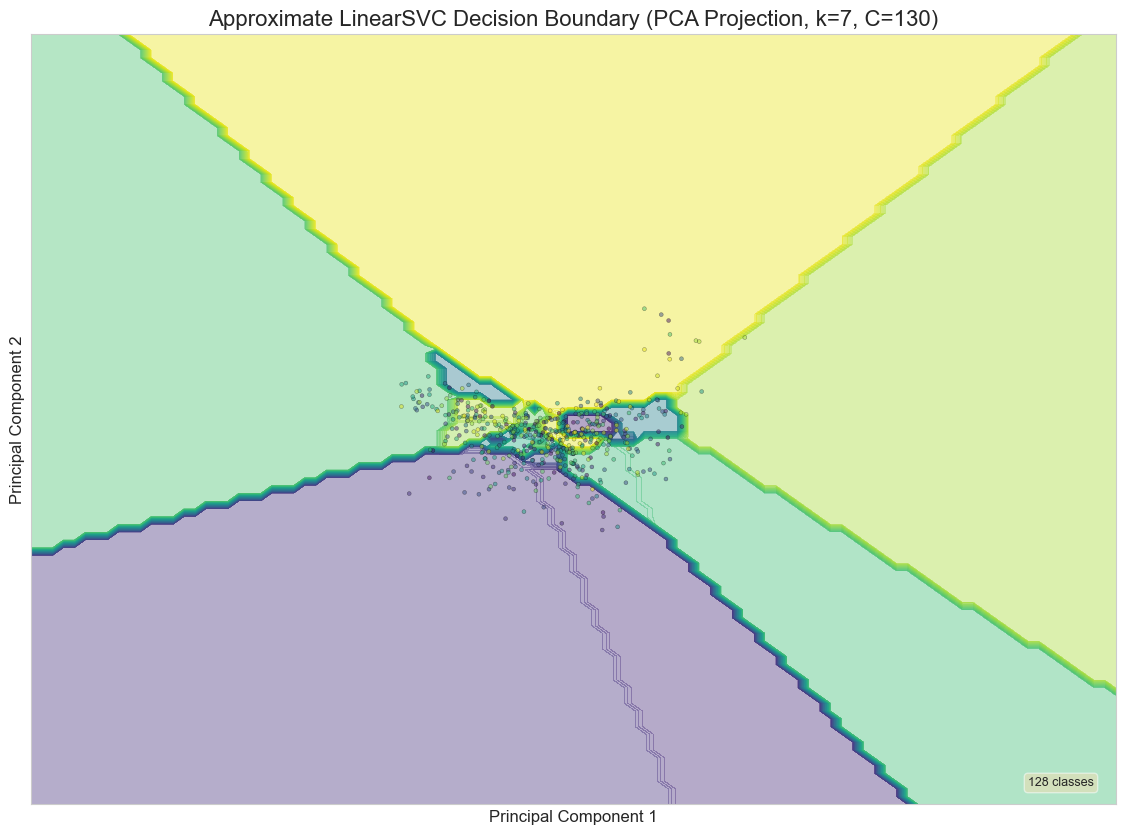


--- End of Visualizations ---
--- End of Script ---


In [8]:
import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA # Added for boundary visualization
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings



# --- Configuration ---
KMER_SIZE = 7
MAX_FEATURES = None
SVM_MAX_ITER = 30000
# GRID_SEARCH_CV_FOLDS = 3 # Not needed after finding the best C
N_JOBS = -1
# Config for visualizations
PCA_N_COMPONENTS = 2
PLOT_SAMPLE_SIZE = 5000
PLOT_GRID_POINTS = 100
FIXED_C = 130

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Step 1: Load data ---
print("Loading dataset...")
start_time = time.time()

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
DATASET_NAME = "tattabio/ec_classification_dna"
df_train = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["train"])
df_test = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["test"])

print(f"Data loading took {time.time() - start_time:.2f} seconds.")
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
df_train.dropna(subset=['Sequence'], inplace=True)
df_test.dropna(subset=['Sequence'], inplace=True)


# --- Step 2: Preprocess sequences ---
print(f"\nGenerating {KMER_SIZE}-mers...")
start_time = time.time()
def kmerize_sequence(seq, k):
    return ' '.join([seq[i:i+k] for i in range(len(seq) - k + 1)])

# Apply k-merization using original .apply method
df_train['kmers'] = df_train['Sequence'].apply(lambda x: kmerize_sequence(x, KMER_SIZE))
df_test['kmers'] = df_test['Sequence'].apply(lambda x: kmerize_sequence(x, KMER_SIZE))
print(f"K-mer generation took {time.time() - start_time:.2f} seconds.")

# --- Step 3: Feature extraction (TF-IDF) ---
print(f"\nExtracting features using TF-IDF (max_features={MAX_FEATURES})...")
start_time = time.time()
vectorizer = TfidfVectorizer(analyzer='word', max_features=MAX_FEATURES, ngram_range=(1, 1))
# These are the original, unscaled features
X_train_high_dim = vectorizer.fit_transform(df_train['kmers'])
X_test_high_dim = vectorizer.transform(df_test['kmers'])
print(f"TF-IDF vectorization took {time.time() - start_time:.2f} seconds.")
print(f"Train feature matrix shape: {X_train_high_dim.shape}")
print(f"Test feature matrix shape: {X_test_high_dim.shape}")

# --- Step 4: Encode labels ---
print("\nEncoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['Label'])
y_test = label_encoder.transform(df_test['Label'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

# --- Step 5: Train LinearSVC Model on ORIGINAL TF-IDF Data ---
# **** This section now exactly matches your original logic ****
print(f"\nTraining LinearSVC with C={FIXED_C} on ORIGINAL TF-IDF data...")
start_time_train = time.time()
# Note: dual=False was explicitly set in your original code block, restoring that.
best_model = LinearSVC(
    C=FIXED_C,
    class_weight='balanced',
    dual=False, # Explicitly match original code
    max_iter=SVM_MAX_ITER,
    random_state=42
)
# Train on the ORIGINAL, UNSCALED TF-IDF data
best_model.fit(X_train_high_dim, y_train)
print(f"Model training took {time.time() - start_time_train:.2f} seconds.")

# --- Step 6: Evaluate on test set & Report ONLY F1 Scores ---
print("\nEvaluating model on the original TF-IDF test set...")
# Predict on the ORIGINAL, UNSCALED TF-IDF test data
y_pred = best_model.predict(X_test_high_dim)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
# --- Modified Output ---
print("\n--- Final F1 Scores ---")
print(f"Final F1 Score on Test Set (macro): {f1_macro:.4f}")
print(f"Final F1 Score on Test Set (weighted): {f1_weighted:.4f}")
# --- End Modified Output ---

###########################################################################
# --- Step 7: Dimensionality Reduction & Boundary Visualization ---
# This section uses the trained model and original data for visualization
###########################################################################
print("\n--- Starting Boundary Visualization ---")

# 7.1: Reduce dimensions using PCA on ORIGINAL TF-IDF training data
# PCA works better on scaled data, but we visualize relative to the unscaled model.
# Converting sparse matrix to dense for PCA can be memory intensive.
print(f"\nApplying PCA to ORIGINAL TF-IDF features to {PCA_N_COMPONENTS} components...")
start_time_pca = time.time()
pca = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
try:
    # Convert sparse matrix to dense for PCA
    X_train_high_dim_dense = X_train_high_dim.toarray() if hasattr(X_train_high_dim, 'toarray') else X_train_high_dim
    X_train_2d = pca.fit_transform(X_train_high_dim_dense)
    del X_train_high_dim_dense # Free memory
    gc.collect()
    print(f"PCA transformation took {time.time() - start_time_pca:.2f} seconds.")
    print(f"Explained variance ratio by {PCA_N_COMPONENTS} components: {pca.explained_variance_ratio_.sum():.4f}")
except MemoryError:
    print("\nMemoryError converting sparse matrix for PCA. Boundary plot cannot be generated.")
    exit()
except Exception as e:
     print(f"Error during PCA: {e}. Boundary plot cannot be generated.")
     exit()

# 7.2: Create Meshgrid in 2D PCA space
print("\nCreating grid and predicting for boundary visualization...")
start_time_viz = time.time()
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, PLOT_GRID_POINTS),
                     np.linspace(y_min, y_max, PLOT_GRID_POINTS))
grid_points_2d = np.c_[xx.ravel(), yy.ravel()]



# Project 2D grid points back to ~original high-dim space
grid_points_high_dim_approx = pca.inverse_transform(grid_points_2d)
# Predict class labels using the model trained on original unscaled data
Z = best_model.predict(grid_points_high_dim_approx)
Z = Z.reshape(xx.shape)
print(f"Grid creation and prediction took {time.time() - start_time_viz:.2f} seconds.")

# 7.4: Plotting
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.4, levels=np.arange(num_classes + 1) - 0.5)

# Subsample training data for plotting on top
if PLOT_SAMPLE_SIZE and PLOT_SAMPLE_SIZE < X_train_2d.shape[0]:
    plot_indices = np.random.choice(X_train_2d.shape[0], PLOT_SAMPLE_SIZE, replace=False)
    X_train_plot = X_train_2d[plot_indices]
    y_train_plot = y_train[plot_indices]
else:
    X_train_plot = X_train_2d
    y_train_plot = y_train

scatter = plt.scatter(X_train_plot[:, 0], X_train_plot[:, 1], c=y_train_plot,
                      cmap='viridis', s=8, alpha=0.5, edgecolor='k', linewidth=0.3)
plt.title(f'Approximate LinearSVC Decision Boundary (PCA Projection, k={KMER_SIZE}, C={FIXED_C})', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
if num_classes <= 30: plt.colorbar(scatter, label='Encoded Class Label')
else: plt.text(0.98, 0.02, f'{num_classes} classes', va='bottom', ha='right',
               transform=plt.gca().transAxes, fontsize=9, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))
plt.xlim(xx.min(), xx.max()); plt.ylim(yy.min(), yy.max())
plt.xticks(()); plt.yticks(())
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import time
import warnings
from tqdm.auto import tqdm
import gc

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


# --- Configuration ---
MAX_SEQUENCE_LENGTH = 512 # Choose max length - smaller reduces dimensionality
SVM_MAX_ITER = 3000
GRID_SEARCH_CV_FOLDS = 3
N_JOBS = -1


ONE_HOT_MAP = {
    'A': np.array([1., 0., 0., 0.]),
    'C': np.array([0., 1., 0., 0.]),
    'G': np.array([0., 0., 1., 0.]),
    'T': np.array([0., 0., 0., 1.]),
    'N': np.array([0., 0., 0., 0.])
}
UNKNOWN_CHAR_VECTOR = np.array([0., 0., 0., 0.])
PADDING_VECTOR = np.array([0., 0., 0., 0.])

# --- Step 1: Load data ---
print("Loading dataset...")
start_time = time.time()

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
DATASET_NAME = "tattabio/ec_classification_dna"
df_train = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["train"])
df_test = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["test"])

print(f"Data loading took {time.time() - start_time:.2f} seconds.")
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

# Drop rows with missing sequences
df_train.dropna(subset=['Sequence'], inplace=True)
df_test.dropna(subset=['Sequence'], inplace=True)


# --- Step 2: One-Hot Encoding Function ---
def one_hot_encode_sequence(sequence, max_len):
    """
    Encodes a DNA sequence using one-hot mapping and pads/truncates
    to a fixed length, then flattens.
    """
    if pd.isna(sequence):
        sequence = ""

    # Ensure uppercase
    sequence = sequence.upper()

    encoded_vectors = []
    seq_len = len(sequence)

    for i in range(max_len):
        if i < seq_len:
            base = sequence[i]

            vector = ONE_HOT_MAP.get(base, UNKNOWN_CHAR_VECTOR)
        else:

            vector = PADDING_VECTOR
        encoded_vectors.append(vector)


    return np.array(encoded_vectors).flatten()

# --- Step 3: Apply Encoding ---
print(f"\nApplying One-Hot Encoding (max_len={MAX_SEQUENCE_LENGTH})...")
start_time = time.time()

X_train_list = [one_hot_encode_sequence(seq, MAX_SEQUENCE_LENGTH) for seq in tqdm(df_train['Sequence'], desc="Encoding Train")]
X_train = np.vstack(X_train_list)

X_test_list = [one_hot_encode_sequence(seq, MAX_SEQUENCE_LENGTH) for seq in tqdm(df_test['Sequence'], desc="Encoding Test")]
X_test = np.vstack(X_test_list)

print(f"One-Hot Encoding took {time.time() - start_time:.2f} seconds.")
print(f"Train feature matrix shape: {X_train.shape}") # Should be (num_samples, max_len * 4)
print(f"Test feature matrix shape: {X_test.shape}")

# Clean up intermediate lists to save memory
del X_train_list, X_test_list
gc.collect()

# --- Step 4: Encode labels ---
print("\nEncoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['Label'])
y_test = label_encoder.transform(df_test['Label'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

# --- Step 5: Grid Search for best LinearSVM ---

n_features = X_train.shape[1]
n_samples = X_train.shape[0]

dual_setting = False if n_samples > n_features else True
print(f"\nUsing dual={dual_setting} for LinearSVC (n_samples={n_samples}, n_features={n_features})")

print("\nStarting Grid Search for LinearSVC on One-Hot Features...")
start_time = time.time()

param_grid = {
    'C': [0.02,0.03,0.04], # Test a range for C
}

svm = LinearSVC(
    class_weight='balanced',
    dual=dual_setting,
    max_iter=SVM_MAX_ITER,
    random_state=42
    )

grid_search = GridSearchCV(
    svm,
    param_grid,
    cv=GRID_SEARCH_CV_FOLDS,
    scoring='f1_macro',
    verbose=2,
    n_jobs=N_JOBS
    )

# Fit on the training data
grid_search.fit(X_train, y_train)

print(f"Grid Search took {time.time() - start_time:.2f} seconds.")
print("Best Parameters found by Grid Search:", grid_search.best_params_)


# --- Step 6: Evaluate on test set ---
print("\nEvaluating best model on the test set...")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print metrics
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n--- Final Results (One-Hot Encoding + LinearSVC) ---")
print(f"Max Sequence Length: {MAX_SEQUENCE_LENGTH}")
print(f"Feature Dimension: {X_train.shape[1]}")
print(f"Best C: {grid_search.best_params_['C']}")
print("-" * 30)
print(f"Final F1 Score on Test Set (macro): {f1_macro:.4f}")
print(f"Final F1 Score on Test Set (weighted): {f1_weighted:.4f}")
print("-" * 30)


Loading dataset...
Data loading took 0.85 seconds.
Train shape: (512, 3), Test shape: (128, 3)

Applying One-Hot Encoding (max_len=512)...


Encoding Train:   0%|          | 0/512 [00:00<?, ?it/s]

Encoding Test:   0%|          | 0/128 [00:00<?, ?it/s]

One-Hot Encoding took 0.16 seconds.
Train feature matrix shape: (512, 2048)
Test feature matrix shape: (128, 2048)

Encoding labels...
Number of classes: 128

Using dual=True for LinearSVC (n_samples=512, n_features=2048)

Starting Grid Search for LinearSVC on One-Hot Features...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Grid Search took 5.36 seconds.
Best Parameters found by Grid Search: {'C': 0.03}

Evaluating best model on the test set...

--- Final Results (One-Hot Encoding + LinearSVC) ---
Max Sequence Length: 512
Feature Dimension: 2048
Best C: 0.03
------------------------------
Final F1 Score on Test Set (macro): 0.0508
Final F1 Score on Test Set (weighted): 0.0508
------------------------------
